# Get solar potential data from coordinates

## Input coordinates to get image 

In [1]:
Lat,Lon = -6.21151,106.74293

In [2]:
#JANGAN TERLALU SERING DI-RUN
#JANGAN TERLALU SERING DI-RUN
#JANGAN TERLALU SERING DI-RUN
#JANGAN TERLALU SERING DI-RUN
#JANGAN TERLALU SERING DI-RUN
#JANGAN TERLALU SERING DI-RUN

import urllib
import os
import math
from PIL import Image

class GoogleMapDownloader:
    """
        A class which generates high resolution google maps images given
        a longitude, latitude and zoom level
    """

    def __init__(self, lat, lng, zoom=22):
        """
            GoogleMapDownloader Constructor
            Args:
                lat:    The latitude of the location required
                lng:    The longitude of the location required
                zoom:   The zoom level of the location required, ranges from 0 - 23
                        defaults to 22 -> 30 meters x 30 meters
        """
        self._lat = lat
        self._lng = lng
        self._zoom = zoom

    def getXY(self):
        """
            Generates an X,Y tile coordinate based on the latitude, longitude 
            and zoom level
            Returns:    An X,Y tile coordinate
        """
        
        tile_size = 256

        # Use a left shift to get the power of 2
        # i.e. a zoom level of 2 will have 2^2 = 4 tiles
        numTiles = 1 << self._zoom

        # Find the x_point given the longitude
        point_x = ((tile_size / 2 + self._lng * tile_size / 360.0) * numTiles // tile_size)

        # Convert the latitude to radians and take the sine
        sin_y = math.sin(self._lat * (math.pi / 180.0))

        # Calulate the y coorindate
        point_y = ((tile_size / 2) + 0.5 * math.log((1+sin_y)/(1-sin_y)) * -(tile_size / (2 * math.pi))) * numTiles // tile_size

        return int(point_x), int(point_y)

    def generateImagewhite(self, **kwargs):
        """
            Generates an image by stitching a number of google map tiles together.
            
            Args:
                start_x:        The top-left x-tile coordinate
                start_y:        The top-left y-tile coordinate
                tile_width:     The number of tiles wide the image should be -
                                defaults to 5
                tile_height:    The number of tiles high the image should be -
                                defaults to 5
            Returns:
                A high-resolution Goole Map image.
        """

        start_x = kwargs.get('start_x', None)
        start_y = kwargs.get('start_y', None)
        tile_width = kwargs.get('tile_width', 3)
        tile_height = kwargs.get('tile_height', 3)

        # Check that we have x and y tile coordinates
        if start_x == None or start_y == None :
            start_x, start_y = self.getXY()

        # Determine the size of the image
        width, height = 256 * tile_width, 256 * tile_height

        #Create a new image of the size require
        map_img = Image.new('RGB', (width,height))

        for x in range(0, tile_width):
            for y in range(0, tile_height) :
                url = 'https://mt0.google.com/vt?x='+str(start_x + x)+'&y='+str(start_y + y)+'&z='+ str(self._zoom)
                current_tile = str(x)+'-'+str(y)
                urllib.request.urlretrieve(url, current_tile)
            
                im = Image.open(current_tile)
                map_img.paste(im, (x*256, y*256))
              
                os.remove(current_tile)

        return map_img
    
    def generateImagefull(self, **kwargs):
        """
            Generates an image by stitching a number of google map tiles together.
            
            Args:
                start_x:        The top-left x-tile coordinate
                start_y:        The top-left y-tile coordinate
                tile_width:     The number of tiles wide the image should be -
                                defaults to 5
                tile_height:    The number of tiles high the image should be -
                                defaults to 5
            Returns:
                A high-resolution Goole Map image.
        """

        start_x = kwargs.get('start_x', None)
        start_y = kwargs.get('start_y', None)
        tile_width = kwargs.get('tile_width', 3)
        tile_height = kwargs.get('tile_height', 3)

        # Check that we have x and y tile coordinates
        if start_x == None or start_y == None :
            start_x, start_y = self.getXY()

        # Determine the size of the image
        width, height = 256 * tile_width, 256 * tile_height

        #Create a new image of the size require
        map_img = Image.new('RGB', (width,height))

        for x in range(0, tile_width):
            for y in range(0, tile_height) :
                url = 'https://mt0.google.com/vt/lyrs=y&?x='+str(start_x + x)+'&y='+str(start_y + y)+'&z='+ str(self._zoom)
                current_tile = str(x)+'-'+str(y)
                urllib.request.urlretrieve(url, current_tile)
            
                im = Image.open(current_tile)
                map_img.paste(im, (x*256, y*256))
              
                os.remove(current_tile)

        return map_img

In [3]:
def imgwhite(lat,lon):
    # get white image
    center_x = 0.0001
    center_y = -0.0001
    gmd = GoogleMapDownloader(lat+center_x,lon+center_y, 22)
    img = gmd.generateImagewhite()
    
    return img

def imgfull(lat,lon):
    # get full image
    center_x = 0.0001
    center_y = -0.0001
    gmd = GoogleMapDownloader(lat+center_x,lon+center_y, 22)
    img = gmd.generateImagefull()
    
    return img

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


img = imgwhite(Lat,Lon)
imgclear = imgfull(Lat,Lon)
#rotate 90 degrees
img = np.asarray(img)
imgclear = np.asarray(imgclear)
W,H = 768, 768
center =(W/2,W/2)
scale = 1
M = cv2.getRotationMatrix2D(center, -30, scale)
img= cv2.warpAffine(img, M, (W, H))
imgclear= cv2.warpAffine(imgclear, M, (W, H))

## Proccess Image to get solar cells

In [5]:
def gethouse(image):
    #capture image of house as rectangle
    house = np.zeros((768,768,3),dtype=np.uint8)
    U,D,L,R = 383,383,383,383
    
    while np.sum(image[U][383])<2.92*255:
        U = U-1
    while np.sum(image[D][383])<2.92*255:
        D = D+1
    while np.sum(image[383][L])<2.92*255:
        L = L-1
    while np.sum(image[383][R])<2.92*255:
        R = R+1
    
    house = cv2.rectangle(house,(L,U),(R,D),[255,255,255],-1)
    
    return house,L,R,U,D

In [6]:
house,L,R,U,D = gethouse(img)

In [44]:
def getsolarpanelsystem():
    #capture images of maximum solar installations
    w = int((1.5/30)*768)
    h = int((1/30)*768)
    if (D-U)/(R-L)>1.5:
        p1 = 0
        panel1 = np.zeros((768,768,3),dtype=np.uint8)
        for i in range(1,int((R-L)/(2*h))):
            for j in range(1,int((R-L-(2*(i+1)*w))/w)):
                left = L+((i+1)*w)
                panel1 = cv2.rectangle(panel1, (left+(j*w),U+((i+1)*h)), (left+((j+1)*w),U+(i*h)), [255,255,0], -1)
                p1 = p1+1

        p2 = 0
        panel2 = np.zeros((768,768,3),dtype=np.uint8)        
        for j in range(1,int((R-L)/(2*h))):
            for i in range(1,int((D-U-(2*(j+1)*w))/w)):
                top = U+((j+1)*w)
                panel2 = cv2.rectangle(panel2, (L+(j*h),top+((i+1)*w)), (L+((j+1)*h),top+(i*w)), [255,255,0], -1)
                p2 = p2+1

        p3 = 0
        panel3 = np.zeros((768,768,3),dtype=np.uint8)
        for i in range(1,int((R-L)/(2*h))):
            for j in range(1,int((R-L-(2*(i+1)*w))/w)):
                left = L+((i+1)*w)
                panel3 = cv2.rectangle(panel3, (left+(j*w),D-((i+1)*h)), (left+((j+1)*w),D-(i*h)), [255,255,0], -1)
                p3 = p3+1        


        p4 = 0
        panel4 = np.zeros((768,768,3),dtype=np.uint8)        
        for j in range(1,int((R-L)/(2*h))):
            for i in range(int((D-U-(2*(j+1)*w))/w)):
                top = U+((j+1)*w)
                panel4 = cv2.rectangle(panel4, (R-(j*h),top+((i+1)*w)), (R-((j+1)*h),top+(i*w)), [255,255,0], -1)
                p4 = p4+1
    else:
        p1 = 0
        panel1 = np.zeros((768,768,3),dtype=np.uint8)
        for i in range(1,int((D-U)/(2*h))):
            for j in range(1,int((R-L-(2*(i+1)*w))/w)):
                left = L+((i+1)*w)
                panel1 = cv2.rectangle(panel1, (left+(j*w),U+((i+1)*h)), (left+((j+1)*w),U+(i*h)), [255,255,0], -1)
                p1 = p1+1

        p2 = 0
        panel2 = np.zeros((768,768,3),dtype=np.uint8)        
        for j in range(1,int((R-L)/(2*h))):
            for i in range(1,int((D-U-(2*(j+1)*w))/w)):
                top = U+((j+1)*w)
                panel2 = cv2.rectangle(panel2, (L+(j*h),top+((i+1)*w)), (L+((j+1)*h),top+(i*w)), [255,255,0], -1)
                p2 = p2+1

        p3 = 0
        panel3 = np.zeros((768,768,3),dtype=np.uint8)
        for i in range(1,int((D-U)/(2*h))):
            for j in range(1,int((R-L-(2*(i+1)*w))/w)):
                left = L+((i+1)*w)
                panel3 = cv2.rectangle(panel3, (left+(j*w),D-((i+1)*h)), (left+((j+1)*w),D-(i*h)), [255,255,0], -1)
                p3 = p3+1        


        p4 = 0
        panel4 = np.zeros((768,768,3),dtype=np.uint8)        
        for j in range(1,int((R-L)/(2*h))):
            for i in range(1,int((D-U-(2*(j+1)*w))/w)):
                top = U+((j+1)*w)
                panel4 = cv2.rectangle(panel4, (R-(j*h),top+((i+1)*w)), (R-((j+1)*h),top+(i*w)), [255,255,0], -1)
                p4 = p4+1
        
    return panel1, panel2, panel3, panel4, p1,p2,p3,p4

In [45]:
#pictures of solar cells and number of solar cells
panel1, panel2, panel3, panel4, p1,p2,p3,p4 = getsolarpanelsystem()

#area of each solar panel system in m^2
area1 = p1*1.5
area2 = p2*1.5
area3 = p3*1.5
area4 = p4*1.5

#total cells and total area of system m^2
p = p1+p2+p3+p4
area = p*1.5

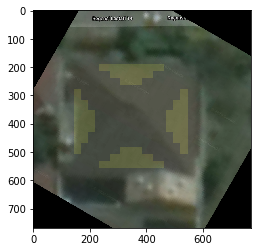

In [46]:
plt.imshow(cv2.addWeighted(panel1+panel2+panel3+panel4,0.1,imgclear,0.9,0))

## Calculate Energy

In [47]:
import pandas as pd

def getdata(lat,lon):
    #3 days forecasting of power generated by installing one 5 kwH solar panel system of 18 cells
    url1 = 'https://api.solcast.com.au/world_pv_power/forecasts?latitude='+str(lat)+'&longitude='+str(lon)+'&capacity=5&tilt=30&azimuth=30&loss_factor=0.75&install_date=2020-04-07&format=csv&api_key=kO-BFvuHeIItv89revn90RXPqF3ZgTYE'
    roof1 = pd.read_csv(url1)
    url2 = 'https://api.solcast.com.au/world_pv_power/forecasts?latitude='+str(lat)+'&longitude='+str(lon)+'&capacity=5&tilt=30&azimuth=120&loss_factor=0.75&install_date=2020-04-07&format=csv&api_key=kO-BFvuHeIItv89revn90RXPqF3ZgTYE'
    roof2 = pd.read_csv(url2)
    url3 = 'https://api.solcast.com.au/world_pv_power/forecasts?latitude='+str(lat)+'&longitude='+str(lon)+'&capacity=5&tilt=30&azimuth=-150&loss_factor=0.75&install_date=2020-04-07&format=csv&api_key=kO-BFvuHeIItv89revn90RXPqF3ZgTYE'
    roof3 = pd.read_csv(url3)
    url4 = 'https://api.solcast.com.au/world_pv_power/forecasts?latitude='+str(lat)+'&longitude='+str(lon)+'&capacity=5&tilt=30&azimuth=-120&loss_factor=0.75&install_date=2020-04-07&format=csv&api_key=kO-BFvuHeIItv89revn90RXPqF3ZgTYE'
    roof4 = pd.read_csv(url4)
    
    return roof1,roof2,roof3,roof4

In [48]:
#forecast data of each system
roof1,roof2,roof3,roof4 = getdata(Lat,Lon)

In [49]:
def allroofs():
    #returns energy generated assuming no change in weather patterns, all system installed
    Eperday = 24*np.average((p1*roof1['PvEstimate'])+(p2*roof2['PvEstimate'])+(p3*roof3['PvEstimate'])+(p4*roof4['PvEstimate']))/18
    Epermonth = 30*Eperday
    Eperyear = 365*Eperday
    
    return Eperday, Epermonth, Eperyear

In [50]:
Eperday, Epermonth, Eperyear =  allroofs()

In [51]:
import operator

def oneroof():
    #returns energy generated assuming no change in weather patterns, best system installed
    my_list = [np.average(p1*roof1['PvEstimate']),np.average(p2*roof2['PvEstimate']),np.average(p3*roof3['PvEstimate']),np.average(p4*roof4['PvEstimate'])]
    index, p = max(enumerate(my_list), key=operator.itemgetter(1))

    E1perday = 24*(p/18)
    E1permonth = 30*E1perday
    E1peryear = 365*E1perday

    return index+1, E1perday, E1permonth, E1peryear

In [52]:
bestroof_index, E1perday, E1permonth, E1peryear =  oneroof()